In [1]:
import json
import pandas as pd
import numpy as np
import argparse
import scipy.stats as sstats
from scipy.stats import exponnorm
from utils import SimulateData

import matplotlib.pyplot as plt

In [2]:
def generate_exgauss_sampler_from_params(param_dict,
                                         default_size=100000):
    def sample_exgauss(size=default_size,
                       param_dict=param_dict):
        out = exponnorm.rvs(param_dict['K'],
                            param_dict['loc'],
                            param_dict['scale'],
                            size=size)
        n_negatives = np.sum(out < 0)
        while n_negatives > 0:
            out[out < 0] = sample_exgauss(n_negatives,
                                          param_dict=param_dict)
            n_negatives = np.sum(out < 0)
        return out

    return sample_exgauss


def get_SSDs(args):
    max_SSD = args.clipped_SSD if args.clip_SSDs_bool else args.max_SSD
    return np.arange(0, max_SSD+50, 50)


def get_args():
    parser = argparse.ArgumentParser(description='ABCD data simulations')
    parser.add_argument('--n_trials_stop', default=2500)
    parser.add_argument('--n_trials_go', default=5000)
#     parser.add_argument('--subjects', nargs='+',
#                         help='subjects to run simulations on', required=True)
    parser.add_argument('--abcd_dir',
                        default='../abcd_data',
                        help='location of ABCD data')
    parser.add_argument('--out_dir',
                        default='../simulated_data/individual_data',
                        help='location to save simulated data')
    parser.add_argument('--clip_SSDs_bool',
                        default=True,
                        help='clip fixed SSD design to clipped SSD instead of max',
                        type=bool)
    parser.add_argument('--max_SSD',
                        default=900,
                        help='max SSD of the dataset')
    parser.add_argument('--clipped_SSD',
                        default=500,
                        help='max SSD to use if dist is clipped')
    args = parser.parse_args([])
    return(args)

In [3]:
    
    print('getting args')
    args = get_args()
    print('analyzing ABCD info')
    # GET ABCD INFO
    # p(guess | signal, SSD)
    p_guess_df = pd.read_csv('%s/p_guess_per_ssd.csv' % args.abcd_dir)
    p_guess_df.columns = p_guess_df.columns.astype(float)

    # exgaus sampler for guesses
    exgauss_param_path = '%s/exgauss_params.json' % args.abcd_dir
    with open(exgauss_param_path, 'r') as f:
        exgauss_params = json.load(f)
    sample_exgauss = generate_exgauss_sampler_from_params(exgauss_params)

    # assigned mus
    with open('%s/assigned_mus.json' % args.abcd_dir) as json_file:
        mus_dict = json.load(json_file)

    # SETUP SIMULATORS
    simulator_dict = {
        'standard': SimulateData(),
        'guesses': SimulateData(guesses=True),
        'graded_go': SimulateData(grade_mu_go=True),
        'graded_both': SimulateData(grade_mu_go=True, grade_mu_stop=True),
    }

    # set up shared params
    SSDs = get_SSDs(args)
    params = {
        'n_trials_stop': 100,
        'n_trials_go': 100,
        'n_trials_tracking_stop': 1000,
        'guess_function': sample_exgauss,
        'SSDs': SSDs,
        'p_guess_stop': list(p_guess_df[SSDs].values.astype(float)[0])
    }

    # SIMULATE INDIVIDUALS
    issue_subs = []
    for sub in ['00J52GPG']:
#         try:
        params['mu_go'] = mus_dict[sub]['go']
        params['mu_stop'] = mus_dict[sub]['stop']

        data_out = {}
        for sim_key in simulator_dict:
            data = simulator_dict[sim_key].simulate(params, method='tracking')
            data_out[sim_key] = data
#                 data.to_csv('%s/%s_%s.csv' % (args.out_dir, sim_key, str(sub)))
#         except KeyError as err:
#             print("KeyError error for sub {0}: {1}".format(sub, err))
#             issue_subs.append(sub)
#             continue
#     if len(issue_subs) > 0:
#         print('issue subs: ', issue_subs)
#     else:
#         print('no problematic subs run here!')

getting args
analyzing ABCD info


/Users/henrymj/Documents/ABCD_simulations/scripts/utils.py:341: RuntimeWarning: divide by zero encountered in log
  return self._at_least_0((np.log(SSD/max_SSD)/4+1) * mu_go)


In [4]:
sim_key

'graded_both'

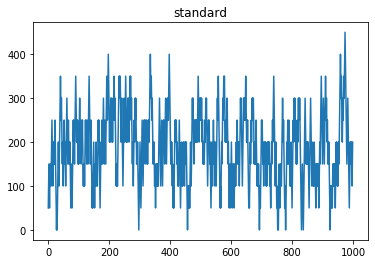

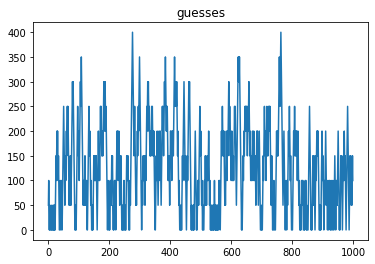

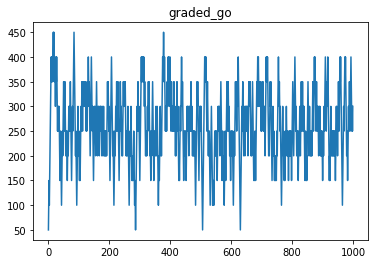

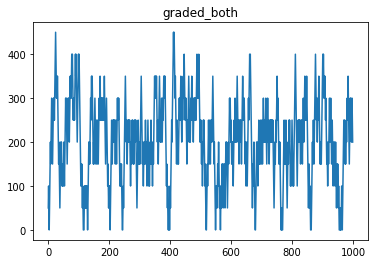

In [5]:
for key in data_out:
    plt.plot(data_out[key].SSD)
    plt.title(key)
    plt.show()
    plt.close()

In [6]:
tracked_data = pd.read_csv('../simulated_data/individual_data_tracking/guesses_00J52GPG.csv', in)

In [7]:
tracked_data

,Unnamed: 0,condition,SSD,trial_idx,mu_go,mu_stop,block,goRT,stopRT,simulation
0,0,stop,50.0,0,0.201717,0.397867,0,NaN,NaN,guesses
1,1,stop,100.0,1,0.201717,0.397867,0,NaN,NaN,guesses
2,2,stop,150.0,2,0.201717,0.397867,0,NaN,NaN,guesses
3,3,stop,200.0,3,0.201717,0.397867,0,NaN,351,guesses
4,4,stop,150.0,4,0.201717,0.397867,0,NaN,[406.68496088],guesses
...,...,...,...,...,...,...,...,...,...,...
29995,29995,go,NaN,4995,0.201717,0.397867,0,842.0,NaN,guesses
29996,29996,go,NaN,4996,0.201717,0.397867,0,416.0,NaN,guesses
29997,29997,go,NaN,4997,0.201717,0.397867,0,710.0,NaN,guesses
29998,29998,go,NaN,4998,0.201717,0.397867,0,445.0,NaN,guesses
